# Набор данных о кино-индустрии
- Предметная область: Индустрия кино. Анализ финансовых показателей проката, популярности жанров, прогнозирование доходов
- Источник: https://www.kaggle.com/datasets/danielgrijalvas/movies
- Тип данных: Реальные данные 7000+ фильмов за 1986-2020 года с ресурса IMDb

Набор применим для:
- Регрессии: Прогнозирования доходности проката фильма на основе доступных данных
- Кластеризация: по бюджету и дохода фильма, по рейтингу

Признаки:

| Тип данных | Признак | Описание                     |
|------------|---------|------------------------------|
| name       | string  | Название фильма              |
| rating     | string  | Возрастной рейтинг           |
| genre      | string  | Жанр                         |
| year       | int64   | Год выпуска                  |
| released   | string  | Дата и место первого проката |
| score      | float64 | Рейтинг IMDb                 |
| votes      | float64 | Количество голосов           |
| director   | string  | Режиссёр                     |
| writer     | string  | Сценарист                    |
| star       | string  | Главный актёр                |
| country    | string  | Страна                       |
| budget     | float64 | Бюджет                       |
| gross      | float64 | Доход                        |
| company    | string  | Продюсер                     |
| runtime    | float64 | Продолжительность в минутах  |

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
from typing import Optional

In [2]:
df = pd.read_csv('raw/movie/movie.csv')
df.drop('released', axis=1)
df.sample(10, random_state=228)

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
2494,North,PG,Adventure,1994,"July 22, 1994 (United States)",4.5,13000.0,Rob Reiner,Alan Zweibel,Elijah Wood,United States,40000000.0,7182747.0,Castle Rock Entertainment,87.0
4126,The Good Girl,R,Drama,2002,"August 30, 2002 (United States)",6.4,44000.0,Miguel Arteta,Mike White,Jennifer Aniston,United States,8000000.0,16860964.0,Flan de Coco Films,93.0
5649,Kick-Ass,R,Action,2010,"April 16, 2010 (United States)",7.6,535000.0,Matthew Vaughn,Jane Goldman,Aaron Taylor-Johnson,United Kingdom,30000000.0,96188903.0,Marv Films,117.0
3382,Dead Man on Campus,R,Comedy,1998,"August 21, 1998 (United States)",6.0,14000.0,Alan Cohn,Anthony Abrams,Tom Everett Scott,United States,14000000.0,15064946.0,Paramount Pictures,96.0
1573,Tap,PG-13,Comedy,1989,"February 10, 1989 (United States)",6.5,1500.0,Nick Castle,Nick Castle,Gregory Hines,United States,NaN,9114702.0,Beco Films,111.0
7486,Anna,R,Action,2019,"June 21, 2019 (United States)",6.6,69000.0,Luc Besson,Luc Besson,Sasha Luss,France,NaN,31626978.0,Summit Entertainment,118.0
4640,Clifford's Really Big Movie,G,Animation,2004,"April 23, 2004 (United States)",5.4,822.0,Robert C. Ramirez,Rhett Reese,John Ritter,United States,70000.0,3255426.0,Big Red Dog Productions,74.0
2690,While You Were Sleeping,PG,Comedy,1995,"April 21, 1995 (United States)",6.7,95000.0,Jon Turteltaub,Daniel G. Sullivan,Sandra Bullock,United States,17000000.0,182057016.0,Hollywood Pictures,103.0
5337,Miss Pettigrew Lives for a Day,PG-13,Comedy,2008,"March 7, 2008 (United States)",7.1,27000.0,Bharat Nalluri,David Magee,Frances McDormand,United Kingdom,NaN,16724933.0,Focus Features,92.0
932,Lady Jane,PG-13,Biography,1986,"February 7, 1986 (United States)",7.1,6300.0,Trevor Nunn,Chris Bryant,Helena Bonham Carter,United Kingdom,8500000.0,277646.0,Capital Equipment Leasing,136.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7668 entries, 0 to 7667
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      7668 non-null   object 
 1   rating    7591 non-null   object 
 2   genre     7668 non-null   object 
 3   year      7668 non-null   int64  
 4   released  7666 non-null   object 
 5   score     7665 non-null   float64
 6   votes     7665 non-null   float64
 7   director  7668 non-null   object 
 8   writer    7665 non-null   object 
 9   star      7667 non-null   object 
 10  country   7665 non-null   object 
 11  budget    5497 non-null   float64
 12  gross     7479 non-null   float64
 13  company   7651 non-null   object 
 14  runtime   7664 non-null   float64
dtypes: float64(5), int64(1), object(9)
memory usage: 898.7+ KB


Видно, что многие целочисленные признаки считались как вещественные. Поправим это

In [4]:
# Convert real values to integers if necessary.
float_features = df.select_dtypes(include='float64').columns
float_features = float_features.dropna()
for feature in float_features:
    func = lambda el: pd.isna(el) or (pd.notna(el) and el.is_integer())
    if df[feature].apply(func).all():
        df[feature] = df[feature].astype('Int64')

Год выпуска (year) часто не совпадает с годом первого показа из released, хотя последний является более важным признаком.

Заменим значения year на год из released, если возможно, а released можно будет удалить

In [5]:
regex = r'(\w+) (\d+), (\d+) \((.+)\)'
for value in df['released']:
    if not re.match(regex, str(value)):
        print(value)

df[df['released'].isna()]

November 1980 (United Kingdom)
1981 (United States)
1982 (Japan)
October 1982 (United States)
March 1992 (United States)
January 1983 (United Kingdom)
August 1983 (United States)
February 1984 (United States)
March 1985 (United States)
September 1987 (United States)
March 1986 (United States)
1985 (Taiwan)
1985 (United States)
October 1986 (United States)
February 1987 (United States)
April 1986 (United States)
1987 (United States)
May 1988 (United Kingdom)
September 1987 (United States)
June 1991 (United States)
May 1989 (United States)
May 1988 (United States)
August 1988 (United States)
October 1988 (United States)
October 1988 (United States)
June 1988 (United States)
March 1989 (United States)
July 1989 (United States)
June 1990 (United States)
April 1990 (United States)
May 1990 (United States)
April 1991 (United States)
April 1991 (United States)
December 1991 (United States)
March 1991 (United States)
April 1991 (United States)
January 1991 (United States)
August 1991 (United S

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
5728,Saw: The Final Chapter,R,Crime,2010,NaN,5.6,93000,Kevin Greutert,Patrick Melton,Tobin Bell,NaN,<NA>,<NA>,NaN,<NA>
5730,The Wolfman,R,Drama,2010,NaN,5.8,104000,Joe Johnston,Andrew Kevin Walker,Benicio Del Toro,NaN,<NA>,<NA>,NaN,<NA>


Имеем значения вида '...{year} ({country})' и два вхождения с NaN, которые вскоре всё равно будут удалены, ведь по ним слишком мало информации

In [6]:
def released_to_year(val_str: str) -> Optional[int]:
    val_str = val_str.split('(')[0].strip()
    return int(val_str[-4:])


func = lambda el: released_to_year(el['released']) if str(el['released']) != 'nan' else el['year']
df['year'] = df.apply(func, axis=1)
df = df.drop('released', axis=1)

In [7]:
# Show how many NaN values are in the table.
columns = df.columns
total_rows = df.shape[0]
no_misses_rows = []
for col in columns:
    nan_count = df[col].isna().sum()
    not_empty = df[col].count()
    if not_empty == total_rows:
        no_misses_rows.append(col)
    else:
        print(f'{col}: NaN={nan_count}, Values={not_empty} of {total_rows} rows')
print(f'Cols without any NaN/Empty: {", ".join(no_misses_rows)}')

rating: NaN=77, Values=7591 of 7668 rows
score: NaN=3, Values=7665 of 7668 rows
votes: NaN=3, Values=7665 of 7668 rows
writer: NaN=3, Values=7665 of 7668 rows
star: NaN=1, Values=7667 of 7668 rows
country: NaN=3, Values=7665 of 7668 rows
budget: NaN=2171, Values=5497 of 7668 rows
gross: NaN=189, Values=7479 of 7668 rows
company: NaN=17, Values=7651 of 7668 rows
runtime: NaN=4, Values=7664 of 7668 rows
Cols without any NaN/Empty: name, genre, year, director


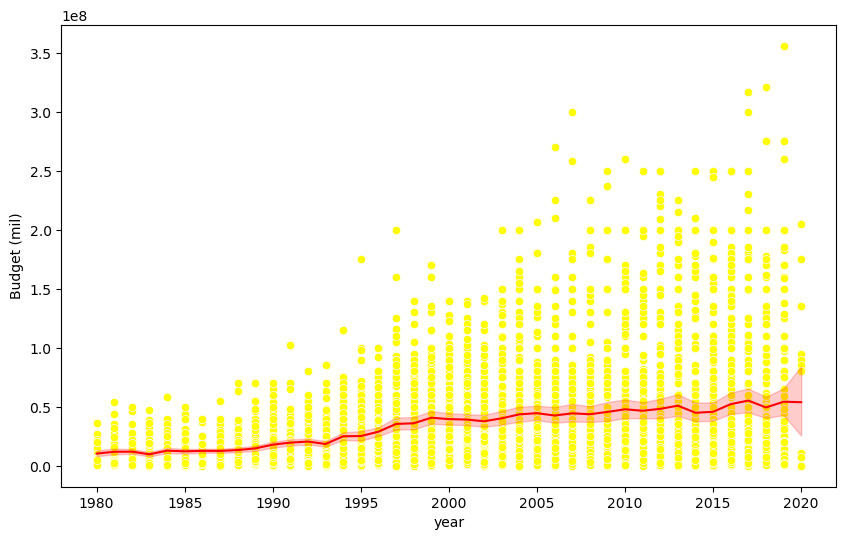

In [8]:
# Show distribution between budget & year.
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='year', y='budget', color='yellow')
sns.lineplot(data=df, x='year', y='budget', color='red')
plt.ylabel('Budget (mil)')
plt.show()

С годами бюджет фильмов растёт. Попробуем заменить NaN на медианные значения бюджета, опираясь на годовые показатели

In [9]:
# Replace budget NaN values.
mean_per_year = df.groupby('year')['budget'].transform('mean').astype('Int64')
df['budget'] = df['budget'].fillna(mean_per_year)
print('NaN values left:', df.isna().sum().sum())
df.isna().sum().sort_values(ascending=False)

NaN values left: 300


gross       189
rating       77
company      17
runtime       4
score         3
votes         3
writer        3
country       3
star          1
name          0
genre         0
year          0
director      0
budget        0
dtype: int64

Записи с неопределенными показателями дохода можно удалить за ненадобностью, останется относительно мало включений с NaN - их тоже можно удалить

In [10]:
df = df.dropna()
print('NaN values left:', df.isna().sum().sum())

NaN values left: 0


### Анализ и визуализация

In [11]:
df.sample(10)

,name,rating,genre,year,score,votes,director,writer,star,country,budget,gross,company,runtime
6654,The Revenant,R,Action,2016,8.0,729000,Alejandro G. Iñárritu,Mark L. Smith,Leonardo DiCaprio,United States,135000000,532950503,New Regency Productions,156
4572,Mean Creek,R,Crime,2004,7.2,31000,Jacob Estes,Jacob Estes,Rory Culkin,United States,500000,802948,Whitewater Films,90
6558,PK,Not Rated,Comedy,2014,8.1,169000,Rajkumar Hirani,Rajkumar Hirani,Aamir Khan,India,44890496,100370104,Rajkumar Hirani Films,153
393,10 to Midnight,R,Crime,1983,6.3,7200,J. Lee Thompson,William Roberts,Charles Bronson,United States,4520000,7175592,Cannon Films,101
3583,Instinct,R,Drama,1999,6.6,32000,Jon Turteltaub,Gerald Di Pego,Anthony Hopkins,United States,80000000,34105207,Spyglass Entertainment,126
7295,Isle of Dogs,PG-13,Animation,2018,7.9,147000,Wes Anderson,Wes Anderson,Bryan Cranston,Germany,49391527,64337744,Indian Paintbrush,101
6378,Jack the Giant Slayer,PG-13,Adventure,2013,6.2,134000,Bryan Singer,Darren Lemke,Nicholas Hoult,United Kingdom,195000000,197687603,New Line Cinema,114
5119,P.S. I Love You,PG-13,Comedy,2007,7.0,203000,Richard LaGravenese,Richard LaGravenese,Hilary Swank,United States,30000000,156835339,Alcon Entertainment,126
2181,Light Sleeper,R,Crime,1992,6.8,6300,Paul Schrader,Paul Schrader,Willem Dafoe,United States,5000000,1055987,Carolco Pictures,103
5868,Bad Teacher,R,Comedy,2011,5.6,196000,Jake Kasdan,Gene Stupnitsky,Cameron Diaz,United States,20000000,216197492,Columbia Pictures,92


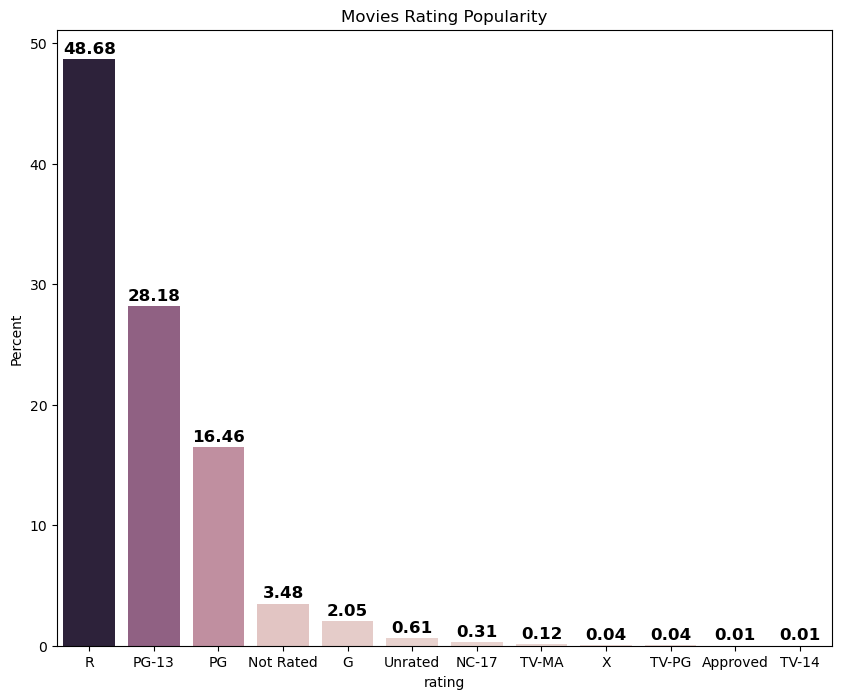

In [12]:
# G - General Audiences (no restrictions);
# PG - Parental Guidance Suggested;
# PG-13 - 13+;
# R - 17+;
# NC-17 - 18+.

data = df['rating'].value_counts()
data = round(data / sum(data) * 100, 2)

plt.figure(figsize=(10, 8))
ax = sns.barplot(
    x=data.index, y=data,
    hue=data, legend=False
)
plt.ylabel('Percent')
plt.title(f'Movies Rating Popularity')
for ind, val in enumerate(data):
    ax.annotate(
        f'{val:.2f}', xy=(ind, val+0.5), ha='center',
        fontsize=12, fontweight='bold'
    )

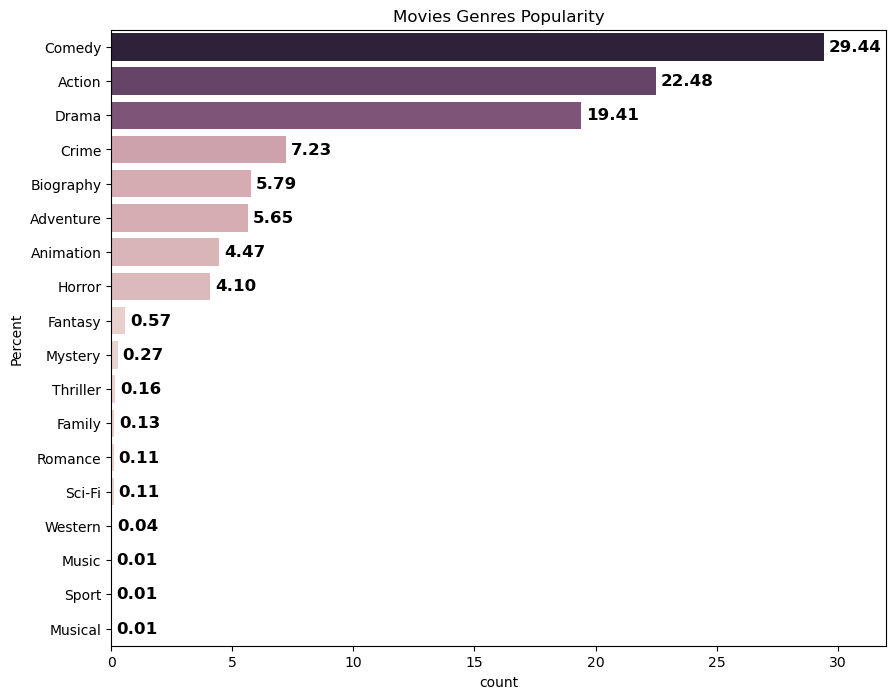

In [13]:
data = df['genre'].value_counts()
data = round(data / sum(data) * 100, 2)

plt.figure(figsize=(10, 8))
ax = sns.barplot(
    x=data,
    y=data.index,
    hue=data,
    legend=False
)
ax.set_xlim(0, 32)
plt.ylabel('Percent')
plt.title('Movies Genres Popularity')
for i, value in enumerate(data):
    ax.annotate(
        f'{value:.2f}', xy=(value+0.2, i), va='center',
        fontsize=12, fontweight='bold'
    )

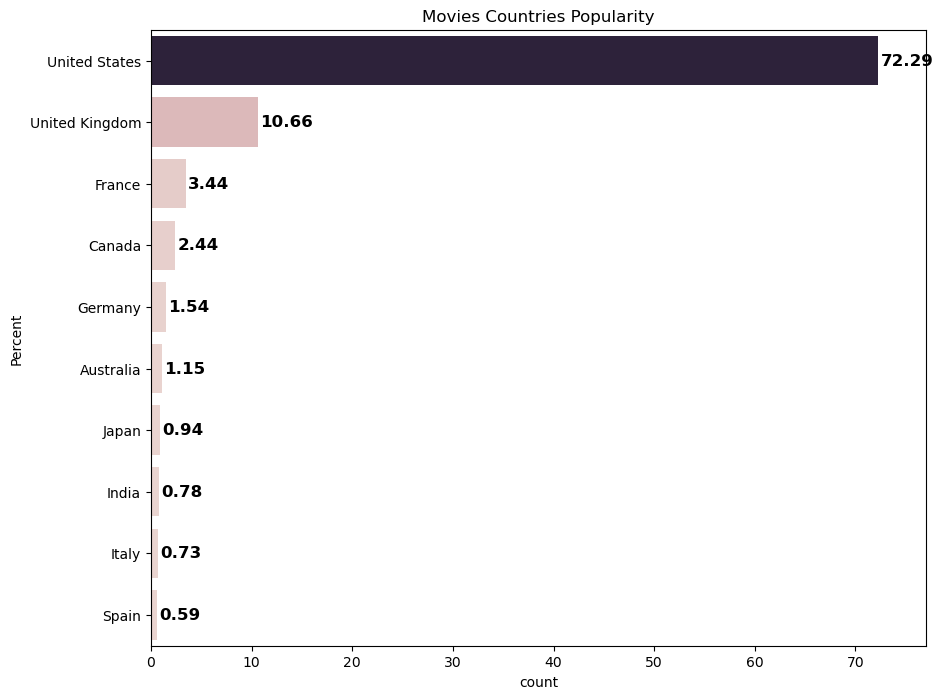

In [14]:
data = df['country'].value_counts()
data = round(data / sum(data) * 100, 2)
data = data[:10]

plt.figure(figsize=(10, 8))
ax = sns.barplot(
    x=data,
    y=data.index,
    hue=data,
    legend=False
)
ax.set_xlim(0, 77)
plt.ylabel('Percent')
plt.title('Movies Countries Popularity')
for i, value in enumerate(data):
    ax.annotate(
        f'{value:.2f}', xy=(value+0.2, i), va='center',
        fontsize=12, fontweight='bold'
    )

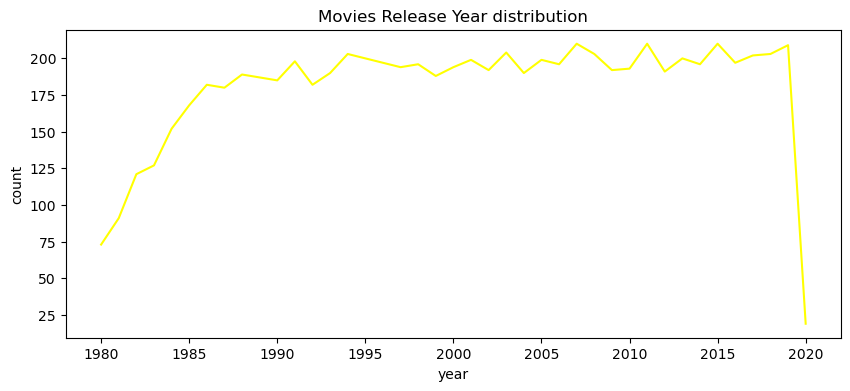

In [15]:
data = df['year'].value_counts()

plt.figure(figsize=(10, 4))
ax = sns.lineplot(x=data.index, y=data, color='yellow')
plt.title('Movies Release Year distribution')
plt.show()

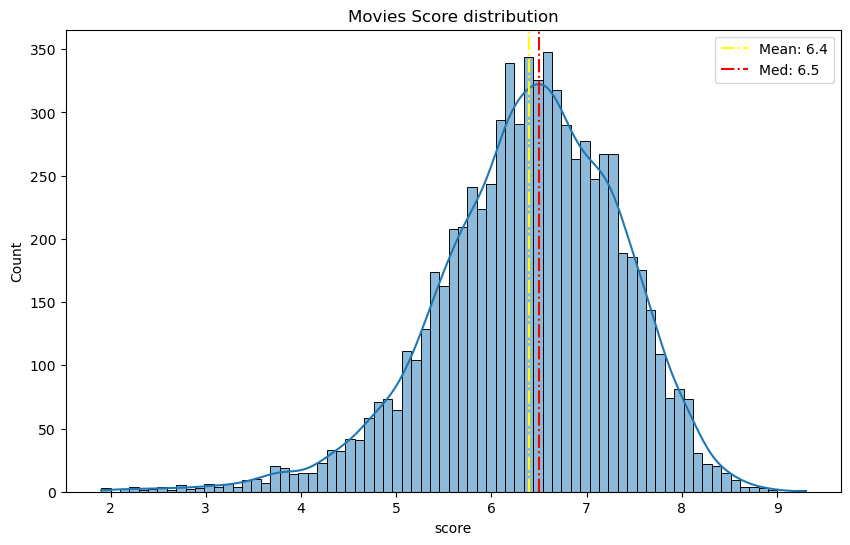

The score data skew: -0.61


In [16]:
data = df['score']

plt.figure(figsize=(10, 6))
plt.title('Movies Score distribution')

# Histogram.
bins = 10 * (data.max() - data.min()) + 1
sns.histplot(data, kde=True, bins=int(bins))

# Median and Mean lines.
mean, med = data.mean(), data.median()
plt.axvline(mean, color='yellow', linestyle='-.', label=f'Mean: {mean:.1f}')
plt.axvline(med, color='red', linestyle='-.', label=f'Med: {med:.1f}')

plt.legend()
plt.show()

print(f'The score data skew: {df["score"].skew(): 0.2f}')

In [17]:
def print_top(df_col: pd.Series, param: str, cnt: int = 5) -> None:
    print(f'Top {cnt} {param} by number of movies')
    for k, v in df_col.value_counts().head(cnt).items():
        print(f'\t{k}: {v}')
    print()

print_top(df['director'], 'directors')
print_top(df['writer'], 'writers')
print_top(df['company'], 'companies')

Top 5 directors by number of movies
	Woody Allen: 38
	Clint Eastwood: 31
	Steven Spielberg: 27
	Directors: 25
	Ron Howard: 24

Top 5 writers by number of movies
	Woody Allen: 37
	Stephen King: 31
	Luc Besson: 25
	John Hughes: 25
	William Shakespeare: 15

Top 5 companies by number of movies
	Universal Pictures: 376
	Warner Bros.: 332
	Columbia Pictures: 332
	Paramount Pictures: 319
	Twentieth Century Fox: 240



In [18]:
print('Top 15 movies of all time (by IMDb rating)')
filtered = df['score'].nlargest(15)
df.loc[filtered.index, ['year', 'name', 'score']]

Top 15 movies of all time (by IMDb rating)


,year,name,score
2443,1994,The Shawshank Redemption,9.3
5243,2008,The Dark Knight,9.0
2247,1994,Schindler's List,8.9
2444,1994,Pulp Fiction,8.9
4245,2003,The Lord of the Rings: The Return of the King,8.9
2445,1994,Forrest Gump,8.8
3444,1999,Fight Club,8.8
3845,2001,The Lord of the Rings: The Fellowship of the Ring,8.8
5643,2010,Inception,8.8
2,1980,Star Wars: Episode V - The Empire Strikes Back,8.7


### Зависимости признаков. Матрица корреляции.

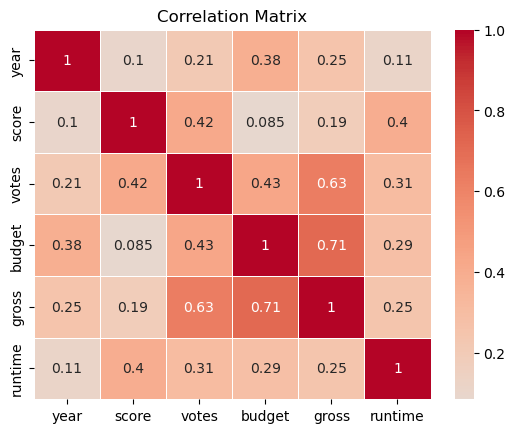

In [19]:
df_numeric = df.select_dtypes(include=[np.number])
corr_matrix = df_numeric.corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

Из матрицы видно:
1. Сильную положительную зависимость gross от budget = 0.71
2. Сильную положительную зависимость gross от votes  = 0.63

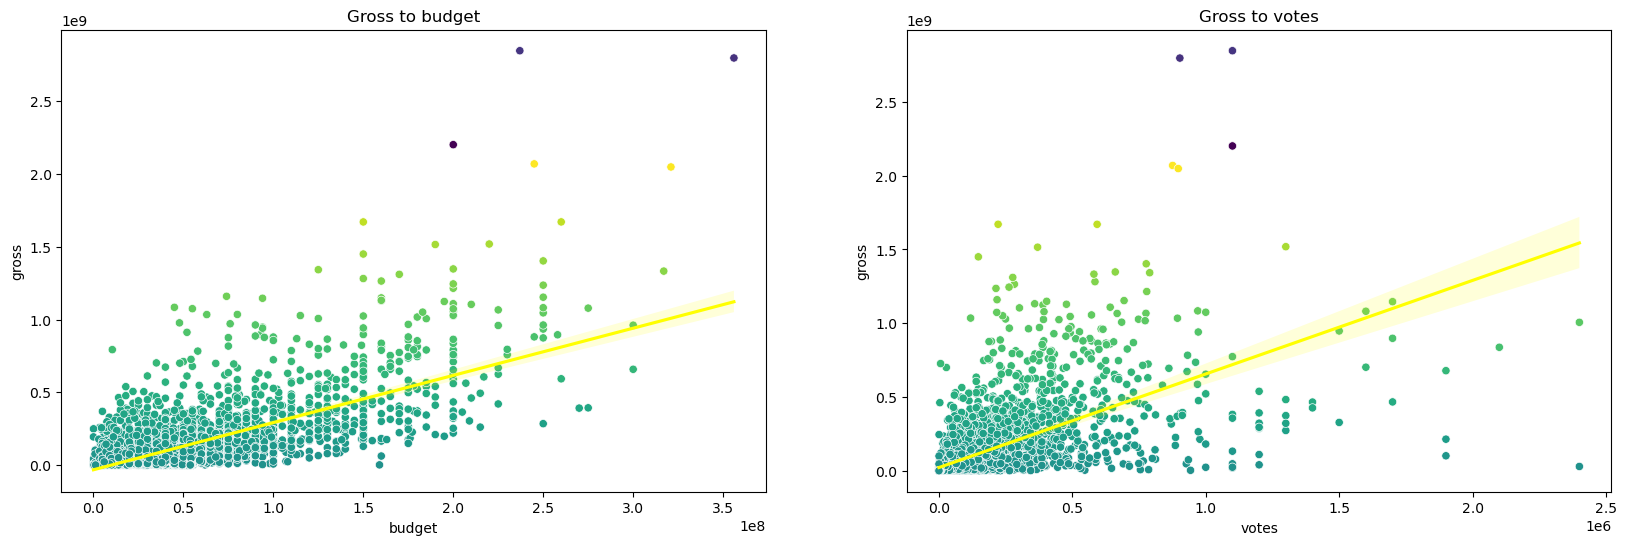

In [20]:
plt.figure(figsize=(20, 6))

# Plot 1: Gross/Budget.
plt.subplot(1, 2, 1)
sns.scatterplot(x='budget', y='gross', data=df, hue=df['gross'].astype(int), legend=False, palette='viridis')
sns.regplot(x='budget', y='gross', data=df, scatter=False, color='yellow')
plt.title('Gross to budget')

# Plot 2: Gross/Votes.
plt.subplot(1, 2, 2)
sns.scatterplot(x='votes', y='gross', data=df, hue=df['gross'].astype(int), legend=False, palette='viridis')
sns.regplot(x='votes', y='gross', data=df, scatter=False, color='yellow')
plt.title('Gross to votes')

plt.show()

Выводы:
1. Чем сильнее растёт бюджет, тем больше доход;
2. Чем больше оценок (тем больше просмотрело людей), тем больше доход.

In [21]:
# New feature: profit.
df['profit'] = df['gross'] - df['budget']
df.sample(10)

,name,rating,genre,year,score,votes,director,writer,star,country,budget,gross,company,runtime,profit
6498,Sex Tape,R,Comedy,2014,5.1,109000,Jake Kasdan,Kate Angelo,Jason Segel,United States,40000000,126069509,Columbia Pictures,94,86069509
4818,Fierce People,R,Drama,2007,6.5,6600,Griffin Dunne,Dirk Wittenborn,Diane Lane,United States,44402981,269755,Industry Entertainment,107,-44133226
6533,Testament of Youth,PG-13,Biography,2015,7.3,27000,James Kent,Vera Brittain,Alicia Vikander,United Kingdom,45700769,5874883,BBC Films,129,-39825886
4969,The Exterminating Angels,Not Rated,Drama,2006,5.4,3100,Jean-Claude Brisseau,Jean-Claude Brisseau,Frédéric van den Driessche,France,42553049,154210,TS Productions,100,-42398839
2331,The Thing Called Love,PG-13,Comedy,1993,6.4,7400,Peter Bogdanovich,Carol Heikkinen,River Phoenix,United States,14000000,1029721,Paramount Pictures,116,-12970279
4368,Radio,PG,Biography,2003,6.9,39000,Michael Tollin,Mike Rich,Cuba Gooding Jr.,United States,35000000,53293628,Revolution Studios,109,18293628
2688,Sabrina,PG,Comedy,1995,6.3,38000,Sydney Pollack,Samuel A. Taylor,Harrison Ford,Germany,58000000,53672080,Constellation Entertainment,127,-4327920
2631,The Inkwell,R,Comedy,1994,6.4,1400,Matty Rich,Trey Ellis,Larenz Tate,United States,24979814,8880705,Touchstone Pictures,110,-16099109
6531,Jack Ryan: Shadow Recruit,PG-13,Action,2014,6.2,126000,Kenneth Branagh,Adam Cozad,Chris Pine,United States,60000000,135503748,Paramount Pictures,105,75503748
6349,Lee Daniels' The Butler,PG-13,Biography,2013,7.2,111000,Lee Daniels,Danny Strong,Forest Whitaker,United States,30000000,177313795,Follow Through Productions,132,147313795


In [22]:
# Save dataframe for further use.
df.to_csv(r'raw/movie/movie_clean.csv', index=False)

### Категоризация, нормализация, подбор числа кластеров K-Means

In [23]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans


# Encode labels.
label_encoder = LabelEncoder()
categorical_features = ['rating', 'genre', 'country']
for feature in categorical_features:
    df[feature] = label_encoder.fit_transform(df[feature])
    
# Get numerical features, normalize.
df_numeric = df.select_dtypes(include=[np.number])
scaler = StandardScaler()
df_numeric = scaler.fit_transform(df_numeric)

# Search for optimal k.
k_range = range(1, 15)
kmeans = [KMeans(n_clusters=i) for i in k_range]
score = [kmeans[i-1].fit(df_numeric).score(df_numeric) for i in k_range]

### Кластеризация K-Means

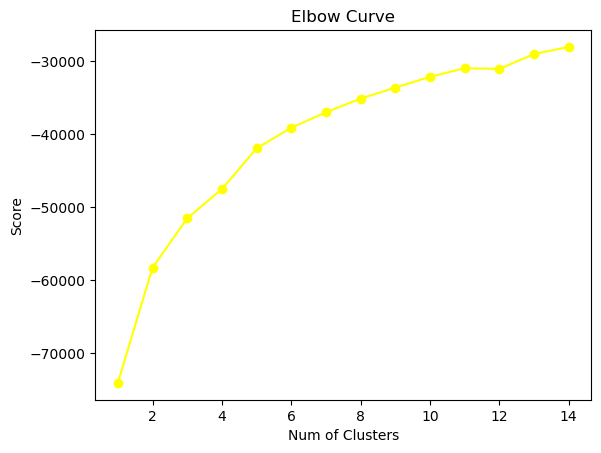

In [24]:
# Show kmeans.
plt.plot(k_range, score, marker='o', color='yellow')
plt.xlabel('Num of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [25]:
optimal_k = 4

kmeans = KMeans(n_clusters=optimal_k)
kmeans.fit(df_numeric)
len(kmeans.labels_)

7412

In [26]:
df_clusters = df.copy()
df_clusters['cluster'] = kmeans.labels_
df_clusters.head()

,name,rating,genre,year,score,votes,director,writer,star,country,budget,gross,company,runtime,profit,cluster
0,The Shining,6,6,1980,8.4,927000,Stanley Kubrick,Stephen King,Jack Nicholson,52,19000000,46998772,Warner Bros.,146,27998772,0
1,The Blue Lagoon,6,1,1980,5.8,65000,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,53,4500000,58853106,Columbia Pictures,104,54353106,2
2,Star Wars: Episode V - The Empire Strikes Back,4,0,1980,8.7,1200000,Irvin Kershner,Leigh Brackett,Mark Hamill,53,18000000,538375067,Lucasfilm,124,520375067,1
3,Airplane!,4,4,1980,7.7,221000,Jim Abrahams,Jim Abrahams,Robert Hays,53,3500000,83453539,Paramount Pictures,88,79953539,2
4,Caddyshack,6,4,1980,7.3,108000,Harold Ramis,Brian Doyle-Murray,Chevy Chase,53,6000000,39846344,Orion Pictures,98,33846344,2


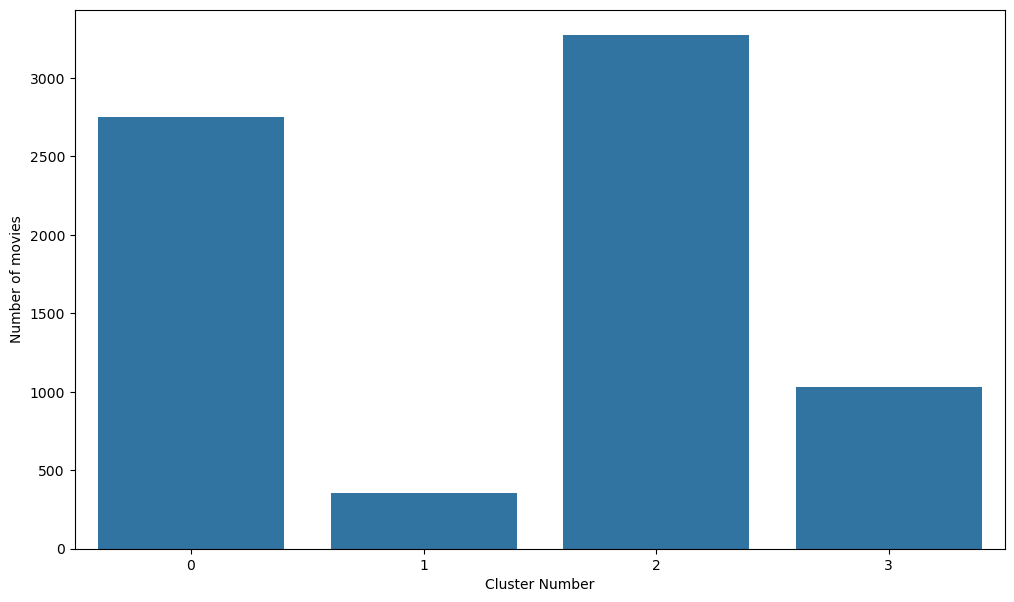

In [27]:
plt.figure(figsize=(12,7))
axis = sns.barplot(
    x=np.arange(0,optimal_k,1), 
    y=df_clusters.groupby(['cluster']).count()['budget'].values
)
x=axis.set_xlabel('Cluster Number')
y=axis.set_ylabel('Number of movies')


In [28]:
df_numeric = df_clusters.select_dtypes(include=[np.number])
df_numeric = df_numeric.groupby('cluster').mean().round(2)

for cluster, count in df_clusters['cluster'].value_counts().sort_index().items():
    print(f'Cluster #{cluster} size: {count}')
    
df_numeric

Cluster #0 size: 2753
Cluster #1 size: 355
Cluster #2 size: 3271
Cluster #3 size: 1033


,rating,genre,year,score,votes,country,budget,gross,runtime,profit
cluster,,,,,,,,,,
0,5.32,3.22,2008.42,6.66,124339.04,52.42,42140876.59,88168264.07,111.92,46027387.49
1,4.71,1.30,2009.25,7.21,537285.92,51.06,134488681.69,654584557.73,125.38,520095876.04
2,5.20,4.00,1992.77,5.98,25044.93,52.55,17971842.19,23352137.7,100.35,5380295.52
3,5.05,3.76,2003.35,6.74,55930.09,14.04,31819453.37,32924124.03,111.84,1104670.65


Можно увидеть следующие группы:
- №0 и №2: Два наибольших кластера - большинство хороших фильмов. Первые выделяются хорошими прибылями profit
- №1: Небольшой кластер - фильмы с малыми прибылями
- №3: Наименьший кластер - фильмы с наибольшими финансовыми показателями

Посмотрим на представителей каждой группы.

In [29]:
# Cluster 0.
df_view = df_clusters.drop(columns=['rating', 'genre', 'country', 'budget', 'gross'])
df_view[df_view['cluster'] == 0].sample(5)

,name,year,score,votes,director,writer,star,company,runtime,profit,cluster
7277,Mandy,2018,6.5,68000,Panos Cosmatos,Panos Cosmatos,Nicolas Cage,SpectreVision,121,-4444797,0
4992,Curious George,2006,6.5,16000,Matthew O'Callaghan,Ken Kaufman,Will Ferrell,Imagine Entertainment,87,19865924,0
6969,The Light Between Oceans,2016,7.2,54000,Derek Cianfrance,Derek Cianfrance,Michael Fassbender,Heyday Films,133,5975621,0
4682,Munich,2006,7.5,216000,Steven Spielberg,Tony Kushner,Eric Bana,Dreamworks Pictures,164,60982129,0
7221,Loveless,2017,7.6,31000,Andrey Zvyagintsev,Oleg Negin,Maryana Spivak,Non-Stop Productions,127,-51298665,0


In [30]:
# Cluster 1.
df_view[df_view['cluster'] == 1].sample(5)

,name,year,score,votes,director,writer,star,company,runtime,profit,cluster
3848,"Monsters, Inc.",2001,8.1,838000,Pete Docter,Pete Docter,Billy Crystal,Pixar Animation Studios,92,464707738,1
6282,Pacific Rim,2013,6.9,475000,Guillermo del Toro,Travis Beacham,Idris Elba,Warner Bros.,131,221002906,1
7087,Transformers: The Last Knight,2017,5.2,140000,Michael Bay,Art Marcum,Mark Wahlberg,Paramount Pictures,154,388425157,1
5080,The Bourne Ultimatum,2007,8.0,612000,Paul Greengrass,Tony Gilroy,Matt Damon,Universal Pictures,115,334100035,1
3057,Men in Black,1997,7.3,529000,Barry Sonnenfeld,Lowell Cunningham,Tommy Lee Jones,Columbia Pictures,98,499390539,1


In [31]:
# Cluster 2.
df_view[df_view['cluster'] == 2].sample(5)

,name,year,score,votes,director,writer,star,company,runtime,profit,cluster
1833,The Haunting of Morella,1990,4.4,694,Jim Wynorski,Edgar Allan Poe,Nicole Eggert,Concorde-New Horizons,82,-16319096,2
4407,The Jungle Book 2,2003,5.4,15000,Steve Trenbirth,Karl Geurs,John Goodman,Disney Television Animation,72,166303759,2
2283,The Secret Garden,1993,7.3,38000,Agnieszka Holland,Frances Hodgson Burnett,Kate Maberly,Warner Bros.,101,13181347,2
3929,The Glass House,2001,5.8,34000,Daniel Sackheim,Wesley Strick,Diane Lane,Columbia Pictures,106,-6380391,2
783,He-Man and She-Ra: The Secret of the Sword,1985,7.3,2600,Directors,Larry DiTillio,John Erwin,Filmation Associates,100,5660857,2


In [32]:
# Cluster 3.
df_view[df_view['cluster'] == 3].sample(5)

,name,year,score,votes,director,writer,star,company,runtime,profit,cluster
4785,The Proposition,2006,7.3,51000,John Hillcoat,Nick Cave,Ray Winstone,UK Film Council,104,-14951307,3
5338,Hunger,2008,7.5,68000,Steve McQueen,Enda Walsh,Stuart Graham,Film4,96,-40447625,3
5031,Everyone's Hero,2006,5.7,8300,Colin Brady,Robert Kurtz,Jake T. Austin,Arc Productions,87,-18372812,3
6133,Rust and Bone,2012,7.5,65000,Jacques Audiard,Jacques Audiard,Marion Cotillard,Why Not Productions,120,-22410558,3
3962,Lagaan: Once Upon a Time in India,2001,8.1,108000,Ashutosh Gowariker,Ashutosh Gowariker,Aamir Khan,Aamir Khan Productions,224,-37400194,3


Действительно, можно наблюдать группу самых удачных прокатов, группу самых неудачных и две посередине. Разница между последними двумя в среднем порядке доходов (разница в десяток)